In [39]:
import pandas as pd

In [40]:
import pickle

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [43]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-taxi-new-experiment")

<Experiment: artifact_location='/workspaces/MLOps-Zoomcamp-Practice/02-ExperimentTracking/mlruns/2', creation_time=1718797605905, experiment_id='2', last_update_time=1718797605905, lifecycle_stage='active', name='my-taxi-new-experiment', tags={}>

In [44]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [45]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

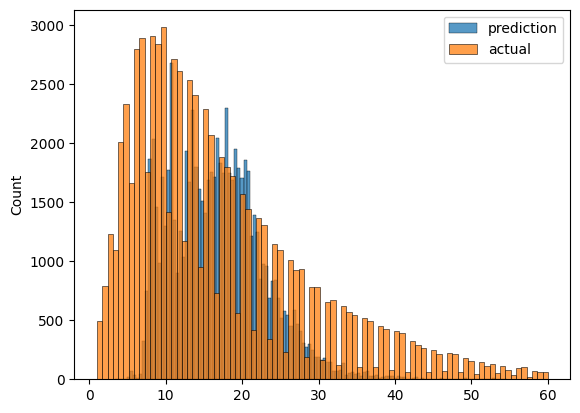

In [46]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [47]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [48]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [49]:
len(df_train), len(df_val) 

(73908, 61921)

In [50]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [51]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [52]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [54]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [55]:
with mlflow.start_run():
   mlflow.set_tag("developer","cristian")

   mlflow.log_param("train_data_path", "./data/green_tripdata_2023-01.parquet")
   mlflow.log_param("vaild_data_path", "./data/green_tripdata_2023-02.parquet")
   alpha = 0.1
   mlflow.log_param("alpha", alpha)
   lr = Lasso(alpha)

   #lr = Lasso(0.01)
   lr.fit(X_train, y_train)

   y_pred = lr.predict(X_val)

   rmse = root_mean_squared_error(y_val, y_pred)

   mlflow.log_metric("rmse", rmse)

   mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [34]:
import xgboost as xgb

In [35]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                 | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:52:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.81537                                                                                                  
[1]	validation-rmse:8.38724                                                                                                  
[2]	validation-rmse:7.57210                                                                                                  
[3]	validation-rmse:7.11953                                                                                                  
[4]	validation-rmse:6.86781                                                                                                  
[5]	validation-rmse:6.72550                                                                                                  
[6]	validation-rmse:6.64455                                                                                                  
[7]	validation-rmse:6.59281                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:54:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.03490                                                                                                  
[1]	validation-rmse:7.67000                                                                                                  
[2]	validation-rmse:7.11939                                                                                                  
[3]	validation-rmse:6.89838                                                                                                  
[4]	validation-rmse:6.81273                                                                                                  
[5]	validation-rmse:6.75885                                                                                                  
[6]	validation-rmse:6.73751                                                                                                  
[7]	validation-rmse:6.72481                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:55:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79249                                                                                                  
[1]	validation-rmse:7.44915                                                                                                  
[2]	validation-rmse:6.94352                                                                                                  
[3]	validation-rmse:6.73582                                                                                                  
[4]	validation-rmse:6.64628                                                                                                  
[5]	validation-rmse:6.60064                                                                                                  
[6]	validation-rmse:6.57813                                                                                                  
[7]	validation-rmse:6.56665                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:56:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.03598                                                                                                  
[1]	validation-rmse:7.67271                                                                                                  
[2]	validation-rmse:7.13164                                                                                                  
[3]	validation-rmse:6.91245                                                                                                  
[4]	validation-rmse:6.81631                                                                                                  
[5]	validation-rmse:6.76591                                                                                                  
[6]	validation-rmse:6.73603                                                                                                  
[7]	validation-rmse:6.71634                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:57:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.35578                                                                                                 
[1]	validation-rmse:9.07895                                                                                                  
[2]	validation-rmse:8.21708                                                                                                  
[3]	validation-rmse:7.65109                                                                                                  
[4]	validation-rmse:7.28382                                                                                                  
[5]	validation-rmse:7.04421                                                                                                  
[6]	validation-rmse:6.88900                                                                                                  
[7]	validation-rmse:6.78659                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:59:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71372                                                                                                 
[1]	validation-rmse:11.25411                                                                                                 
[2]	validation-rmse:10.83226                                                                                                 
[3]	validation-rmse:10.44417                                                                                                 
[4]	validation-rmse:10.08866                                                                                                 
[5]	validation-rmse:9.76218                                                                                                  
[6]	validation-rmse:9.46465                                                                                                  
[7]	validation-rmse:9.19249                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:03:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73565                                                                                                 
[1]	validation-rmse:9.61153                                                                                                  
[2]	validation-rmse:8.77056                                                                                                  
[3]	validation-rmse:8.14810                                                                                                  
[4]	validation-rmse:7.69246                                                                                                  
[5]	validation-rmse:7.36321                                                                                                  
[6]	validation-rmse:7.12703                                                                                                  
[7]	validation-rmse:6.95606                                                                                           

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:06:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.11123                                                                                       
[1]	validation-rmse:8.77047                                                                                        
[2]	validation-rmse:7.94530                                                                                        
[3]	validation-rmse:7.44965                                                                                        
[4]	validation-rmse:7.15331                                                                                        
[5]	validation-rmse:6.97691                                                                                        
[6]	validation-rmse:6.87139                                                                                        
[7]	validation-rmse:6.80058                                                                                        
[8]	validation-rmse:6.75452                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:08:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.40630                                                                                        
[1]	validation-rmse:6.67233                                                                                        
[2]	validation-rmse:6.53663                                                                                        
[3]	validation-rmse:6.49813                                                                                        
[4]	validation-rmse:6.47665                                                                                        
[5]	validation-rmse:6.46844                                                                                        
[6]	validation-rmse:6.46231                                                                                        
[7]	validation-rmse:6.44970                                                                                        
[8]	validation-rmse:6.44102                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:09:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.70299                                                                                        
[2]	validation-rmse:7.88974                                                                                        
[3]	validation-rmse:7.41148                                                                                        
[4]	validation-rmse:7.13316                                                                                        
[5]	validation-rmse:6.96709                                                                                        
[6]	validation-rmse:6.86806                                                                                        
[7]	validation-rmse:6.80632                                                                                        
[8]	validation-rmse:6.76888                                                                                        
[9]	validation-rmse:6.74132                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:10:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.70405                                                                                        
[3]	validation-rmse:8.12109                                                                                        
[4]	validation-rmse:7.71435                                                                                        
[5]	validation-rmse:7.43421                                                                                        
[6]	validation-rmse:7.23659                                                                                        
[7]	validation-rmse:7.09962                                                                                        
[8]	validation-rmse:7.00295                                                                                        
[9]	validation-rmse:6.93491                                                                                        
[10]	validation-rmse:6.88618                                            

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:11:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51988                                                                                       
[1]	validation-rmse:10.90180                                                                                       
[2]	validation-rmse:10.35283                                                                                       
[3]	validation-rmse:9.86625                                                                                        
[4]	validation-rmse:9.43664                                                                                        
[5]	validation-rmse:9.05690                                                                                        
[6]	validation-rmse:8.72455                                                                                        
[7]	validation-rmse:8.43140                                                                                        
[8]	validation-rmse:8.17509                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:16:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.31361                                                                                        
[1]	validation-rmse:7.16002                                                                                        
[2]	validation-rmse:6.83745                                                                                        
[3]	validation-rmse:6.73274                                                                                        
[4]	validation-rmse:6.69498                                                                                        
[5]	validation-rmse:6.67909                                                                                        
[6]	validation-rmse:6.67104                                                                                        
[7]	validation-rmse:6.66432                                                                                        
[8]	validation-rmse:6.65647                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:17:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.72029                                                                                       
[1]	validation-rmse:9.59888                                                                                        
[2]	validation-rmse:8.77037                                                                                        
[3]	validation-rmse:8.16445                                                                                        
[4]	validation-rmse:7.72666                                                                                        
[5]	validation-rmse:7.41670                                                                                        
[6]	validation-rmse:7.19329                                                                                        
[7]	validation-rmse:7.03333                                                                                        
[8]	validation-rmse:6.91974                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:18:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37523                                                                                        
[1]	validation-rmse:7.10796                                                                                        
[2]	validation-rmse:6.72018                                                                                        
[3]	validation-rmse:6.58342                                                                                        
[4]	validation-rmse:6.52125                                                                                        
[5]	validation-rmse:6.49490                                                                                        
[6]	validation-rmse:6.48098                                                                                        
[7]	validation-rmse:6.46688                                                                                        
[8]	validation-rmse:6.46033                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:19:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.11178                                                                                       
[1]	validation-rmse:10.21149                                                                                       
[2]	validation-rmse:9.47512                                                                                        
[3]	validation-rmse:8.88576                                                                                        
[4]	validation-rmse:8.41162                                                                                        
[5]	validation-rmse:8.03505                                                                                        
[6]	validation-rmse:7.73253                                                                                        
[7]	validation-rmse:7.49574                                                                                        
[8]	validation-rmse:7.30877                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:23:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77123                                                                                       
[1]	validation-rmse:11.35978                                                                                       
[2]	validation-rmse:10.97721                                                                                       
[3]	validation-rmse:10.62183                                                                                       
[4]	validation-rmse:10.29177                                                                                       
[5]	validation-rmse:9.98583                                                                                        
[6]	validation-rmse:9.70223                                                                                        
[7]	validation-rmse:9.44025                                                                                        
[8]	validation-rmse:9.19832                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:31:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52180                                                                                       
[1]	validation-rmse:10.90666                                                                                       
[2]	validation-rmse:10.36085                                                                                       
[3]	validation-rmse:9.87869                                                                                        
[4]	validation-rmse:9.45276                                                                                        
[5]	validation-rmse:9.07750                                                                                        
[6]	validation-rmse:8.74884                                                                                        
[7]	validation-rmse:8.46133                                                                                        
[8]	validation-rmse:8.21084                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:34:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.80213                                                                                        
[1]	validation-rmse:6.59330                                                                                        
[2]	validation-rmse:6.55671                                                                                        
[3]	validation-rmse:6.54070                                                                                        
[4]	validation-rmse:6.51921                                                                                        
[5]	validation-rmse:6.50968                                                                                        
[6]	validation-rmse:6.50212                                                                                        
[7]	validation-rmse:6.49752                                                                                        
[8]	validation-rmse:6.49088                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.36854                                                                                       
[1]	validation-rmse:9.09852                                                                                        
[2]	validation-rmse:8.24498                                                                                        
[3]	validation-rmse:7.68386                                                                                        
[4]	validation-rmse:7.32063                                                                                        
[5]	validation-rmse:7.08411                                                                                        
[6]	validation-rmse:6.92741                                                                                        
[7]	validation-rmse:6.81892                                                                                        
[8]	validation-rmse:6.74701                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70335                                                                                       
[1]	validation-rmse:11.23533                                                                                       
[2]	validation-rmse:10.80702                                                                                       
[3]	validation-rmse:10.41378                                                                                       
[4]	validation-rmse:10.05572                                                                                       
[5]	validation-rmse:9.72905                                                                                        
[6]	validation-rmse:9.43074                                                                                        
[7]	validation-rmse:9.15979                                                                                        
[8]	validation-rmse:8.91259                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:39:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20953                                                                                       
[1]	validation-rmse:10.37092                                                                                       
[2]	validation-rmse:9.67498                                                                                        
[3]	validation-rmse:9.10397                                                                                        
[4]	validation-rmse:8.63496                                                                                        
[5]	validation-rmse:8.25094                                                                                        
[6]	validation-rmse:7.94139                                                                                        
[7]	validation-rmse:7.69056                                                                                        
[8]	validation-rmse:7.48523                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.32230                                                                                       
[1]	validation-rmse:10.55851                                                                                       
[2]	validation-rmse:9.90683                                                                                        
[3]	validation-rmse:9.35429                                                                                        
[4]	validation-rmse:8.88269                                                                                        
[5]	validation-rmse:8.49031                                                                                        
[6]	validation-rmse:8.16009                                                                                        
[7]	validation-rmse:7.88402                                                                                        
[8]	validation-rmse:7.65363                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:50:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21405                                                                                       
[1]	validation-rmse:10.37455                                                                                       
[2]	validation-rmse:9.67504                                                                                        
[3]	validation-rmse:9.09382                                                                                        
[4]	validation-rmse:8.61207                                                                                        
[5]	validation-rmse:8.21923                                                                                        
[6]	validation-rmse:7.89894                                                                                        
[7]	validation-rmse:7.63695                                                                                        
[8]	validation-rmse:7.42503                                             

/home/codespace/anaconda3/envs/02-ExperimentTracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:53:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49340                                                                                       
[1]	validation-rmse:10.86009                                                                                       
[2]	validation-rmse:10.29866                                                                                       
[3]	validation-rmse:9.80973                                                                                        
[4]	validation-rmse:9.38019                                                                                        
[5]	validation-rmse:9.00811                                                                                        
[6]	validation-rmse:8.68057                                                                                        
[7]	validation-rmse:8.39505                                                                                        
[8]	validation-rmse:8.15123                                             

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        